# Example: Falling spectrum

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Generate truth, reco, pseudodata

Sample 1000 truth events from $f(x) = e^{-x}$ between $1 < x < 5$.

The reco samples are produced by smearing the truth by a drawing from a Gaussian distribution with $\mu=x$, $\sigma=0.2\sqrt{x}$.

In [2]:
# Monte Carlo from transformation method
def generate_truth(low, high, size):
    rnd = np.random.uniform(1-np.exp(-low),      # 1-exp(-x) is the exp CDF
                            1-np.exp(-high),
                            size=size)
    return -np.log(1-rnd)                        # -log(1-r) is the exp quantile function

In [3]:
np.random.seed(5421)

truth_bins = np.linspace(1, 5, 20+1)
truth_bin_centers = (truth_bins[:-1] + truth_bins[1:]) / 2

reco_bins = np.linspace(0.5, 5, 30+1)
reco_bin_centers = (reco_bins[:-1] + reco_bins[1:]) / 2

N = 1000
a = 200.0 # Multiplier to remove statistical fluctuations from response
truth_events = generate_truth(1, 5, int(N*a))
reco_events = np.random.normal(truth_events, 0.2*np.sqrt(truth_events))

truth_hist, be = np.histogram(truth_events, bins=truth_bins)
truth_hist = truth_hist / a

reco_hist, be = np.histogram(reco_events, bins=reco_bins)
reco_hist = reco_hist / a

data_hist = np.random.poisson(reco_hist)

In [4]:
from helpers import plot_hist
plt.figure(figsize=(6,4.5))
plot_hist(np.append([0], truth_hist), np.append([0.5], truth_bins), has_overflow=False, color='k', lw=1, zorder=0, label='$\mathbf{\mu}$')
plot_hist(reco_hist, reco_bins, has_overflow=False, color='k', lw=1, ls='--', zorder=1, label=r'$\mathbf{\nu}$')
plt.errorbar(reco_bin_centers, data_hist, yerr=np.sqrt(data_hist), fmt='ok', ms=3, capsize=2, lw=1, zorder=2, label='$\mathbf{n}$')
plt.legend(frameon=False)
plt.xlabel('x')
plt.ylabel('Events per bin')
plt.show()

ModuleNotFoundError: No module named 'helpers'

## 2. Response matrix

In [5]:
def response_matrix(truth, reco):
    r = np.histogram2d(reco, truth, bins=(reco_bins, truth_bins))[0]
    norm = r.sum(axis=0, keepdims=True)
    return r / norm

R = response_matrix(truth_events, reco_events)

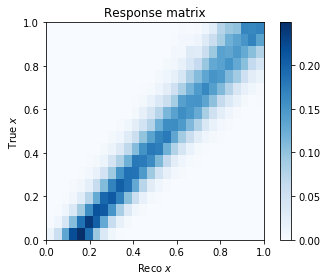

In [6]:
plt.imshow(R.T[1:-1,1:-1], cmap='Blues', origin='lower', extent=(0,1,0,1))
plt.colorbar()
plt.title('Response matrix')
plt.xlabel('Reco $x$')
plt.ylabel('True $x$')
plt.show()

## 3. ML estimator

Since $M \neq N$, $R$ is not invertable. Therefore we solve for the ML estimator as the argmax of the likelihood (minimum of negative log-likelihood).

In [7]:
from iminuit import Minuit
from iminuit.util import make_func_code

from helpers import hist2args, vals2hist, cov2array

# See https://iminuit.readthedocs.io/en/latest/api.html#minuit
class NLL(object):
    def __init__(self):
        params = ['bin_{}'.format(i+1) for i in range(len(truth_bins)-1)]
        self.func_defaults = None
        self.func_code = make_func_code(params)
        
    def default_errordef(self):
        return 0.5
        
    def __call__(self, *args):
        mu = np.array(args, dtype=float)
        nu = np.dot(R, mu)
        if np.any(nu < 0):
            return 1e12
        vec = data_hist * np.log(nu/data_hist) - nu + data_hist
        return -np.sum(vec)

In [8]:
nll = NLL()
minuit = Minuit(nll, **hist2args(data_hist[:20]))
migrad = minuit.migrad()
mu, std = vals2hist(minuit)
cov = cov2array(minuit)

FCN = 2.00332383124 
 TOTAL NCALL = 2784 
 NCALLS = 2784 
 
 
 EDM = 4.95984069854e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,bin_1,134.13,56.9249,0,0,,,
2,bin_2,343.451,195.3,0,0,,,
3,bin_3,-161.341,375.833,0,0,,,
4,bin_4,325.117,483.199,0,0,,,
5,bin_5,104.258,475.669,0,0,,,
6,bin_6,-124.455,499.706,0,0,,,
7,bin_7,217.744,510.949,0,0,,,
8,bin_8,-44.233,393.79,0,0,,,
9,bin_9,159.32,273.789,0,0,,,
10,bin_10,-174.059,274.055,0,0,,,


ML estimator: [ 134.12973242  343.45143291 -161.34091522  325.11653498  104.2582672
 -124.45543663  217.74380757  -44.23296181  159.32023526 -174.05936969
    3.28481529  402.94271952 -312.90866093 -107.98546172  296.77162083
    3.21611993  -62.44833663  -22.22698607  -85.78799241  111.27291337]
ML covariance:


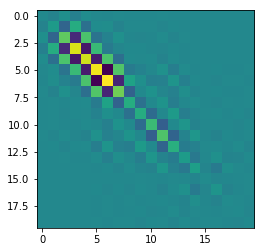

In [9]:
print "ML estimator: %s" % mu
print "ML covariance:"
plt.imshow(cov)
plt.show()

## 4. Gaussian Process MAP estimator

In [10]:
X = truth_bin_centers.reshape(-1, 1)

Define the kernel function. These can be swapped below to investigate the effect of changing the kernel.

In [11]:
def tikhonovKernel(a, b, params):
    R = Xtrain[-1] - Xtrain[0] + np.finfo(float).eps # Maximum difference
    r = a - b.T
    return (2*np.abs(r)**3 - 3*R*(r**2) + R**3) * (np.exp(params)/12)

def sqExpKernel(a, b, params):
    amp, param = params
    sqdist = np.sum(a**2, 1).reshape(-1, 1) + np.sum(b**2, 1) - 2*np.dot(a, b.T)
    return np.exp(amp) * np.exp(-.5 * (1/param) * sqdist)

def gibbsKernel(a, b, params):
    A, t1, t2 = params
    length = lambda x: t1*x + t2
    sqdist = np.sum(a**2, 1).reshape(-1, 1) + np.sum(b**2, 1) - 2*np.dot(a, b.T)
    norm = np.sqrt(2 * length(a) * length(b.T) / (length(a)**2 + length(b.T)**2))
    return np.exp(A) * norm * np.exp(-sqdist/(length(a)**2 + length(b.T)**2))

def gibbsKernel2(a, b, params):
    A, t1, t2, p1, p2 = params
    length = lambda x: t1*x + t2
    sqdist = np.sum(a**2, 1).reshape(-1, 1) + np.sum(b**2, 1) - 2*np.dot(a, b.T)
    norm = np.sqrt(2 * length(a) * length(b.T) / (length(a)**2 + length(b.T)**2))
    amp = A * np.exp((p1 - a - b.T)/(2*p2))
    return amp * norm * np.exp(-sqdist/(length(a)**2 + length(b.T)**2))

### 4.1. Optimise kernel parameters

Optimise the kernel parameters by minimising the negative log marginal likelihood, given by $$-\log L \sim  \mu_{ML}^T[K+U_{ML}]^{-1} \mu_{ML} + \log[ \det (K+U_{ML}) ] + \ldots$$ to find the kernel parameters.

In [12]:
from scipy.linalg import solve

def marginal_llh(params, kernel=gibbsKernel):
    K = kernel(X, X, params)
    if np.isnan(K).any():
        return 1e12
    alpha = solve(K + cov, mu)
    return np.dot(mu, alpha) + np.log(np.linalg.det(K+cov))

In [13]:
from scipy.optimize import minimize

kernel = gibbsKernel
x0 = [10, 1, 1]
res = minimize(marginal_llh, x0, method='L-BFGS-B', args=(kernel))
print(res)

      fun: 200.59726851066546
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-8.12008238e-03,  9.66338121e-05,  1.81898940e-04])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 164
      nit: 25
   status: 0
  success: True
        x: array([  9.44133959, 170.94503702, -91.32196314])


### 4.2. Find MAP estimator
The GP MAP estimator (with zero mean function) is given by $$ \mu = K[K+U_{ML}]^{-1} \mu_{ML} $$ and covariance $$U = K - K[K+U_{ML}]^{-1}K$$

In [14]:
def GP_predict(params, kernel=gibbsKernel):
    K = kernel(X, X, params)
    alpha = solve(K + cov, mu)
    mu_gp = np.dot(K, alpha)
    cov_gp = K - np.dot(K, solve(K+cov, K))
    return mu_gp, cov_gp

In [15]:
mu_gp, cov_gp = GP_predict(res.x, kernel)
std_gp = np.sqrt(np.diag(cov_gp))

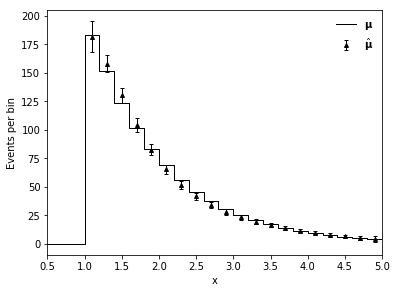

In [16]:
plt.figure(figsize=(6,4.5))
plot_hist(np.append([0], truth_hist), np.append([0.5], truth_bins), has_overflow=False, label='$\mathbf{\mu}$', c='k', lw=1, zorder=0)
plt.errorbar(truth_bin_centers, mu_gp, yerr=std_gp, fmt='^k', ms=4, capsize=2, lw=1, label='$\hat\mathbf{\mu}$')
plt.legend(frameon=False)
plt.xlabel('x')
plt.ylabel('Events per bin')
plt.show()

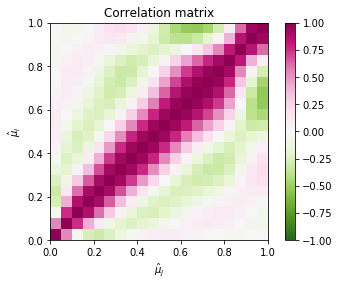

In [17]:
corr = cov_gp / np.sqrt(cov_gp.diagonal() * cov_gp.diagonal().reshape((-1 ,1)))

plt.imshow(corr, origin='lower', extent=(0, 1, 0, 1), cmap='PiYG_r', vmin=-1, vmax=1)
plt.title('Correlation matrix')
plt.xlabel('$\hat{\mu}_j$')
plt.ylabel('$\hat{\mu}_i$')
plt.colorbar()
plt.show()